# Deep RL Home Work 1

_Author: Kay Ke (kayke@uw.edu)_

_Update: Sep 13, 2017_

The file contains the solution for homework 1 for the [Deep Reinforcement Learning Course](http://rll.berkeley.edu/deeprlcourse/). It trains a simple neural network of 64 units activated by ReLU to conduct Behavioral Cloning and DAgger, which is supervised learning to learn a mapping from a set of observations to actions. 

Behavior cloning requires a series of experts' observations and their corresponding actions. The homework was offered some experts which will respond to OpenAI gym environment observation. The program will stimulate the expert in such environments and use their behaviors as training data.

DAgger requires a trained agent and an expert labeler. In stimulating the trained agent in an environment, the agent will likely deviate from the expert's behavior that it was trained on. As the agent's "mistakes" accumulates, the state it ended up will likely to deviate from the "correct" path that would happen if the expert has been acting. DAgger asks the expert labeler to inform the correct action along the "wrong" path of the agent and aggregate the newly obtained data to train the agent. 

The program will output several graphs. Fig 1 demonstrates that the behavior cloning is effectly learning the expert behavior, i.e. the trained loss decreases over iterations. Fig 2 compares the changes in loss when the agent is trained with behavior cloning versus DAgger. 


In [1]:
# The typical imports
%matplotlib inline

# DotDict
class DotDict(dict):
    def __getattr__(self, name):
        return self[name]

# Pass Arguments
args = DotDict({
    'batch_size': 128,  # Number of training data for each epoch
    'epochs': 50, # Number of epoch in training the model
    'envname':'Hopper-v1',  # Environment to stimulate the expert
    'expert_policy_file' : 'experts/Hopper-v1.pkl',  # Read expert from file
    'num_rollouts' : 5,  # Number of rollouts to play for each iter of training
    'render' : False,  # Whether to render the final training result in animation
    'max_timesteps' : 300,  # Stop the env after this number of steps being taken
    'verbose' : 1,  # Verbose level of program log. 0 = most silent, 3 = all logs
})

# Generate plt
def gen_new_plot(title, ylabel, xlabel):
    fig, ax = plt.subplots( nrows=1, ncols=1 )
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    return ax

# Suppress Tensorflow warning complaining about not using certain instruction sets
# Arises when not install tensorflow from source
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [2]:
#!/usr/bin/env python

"""
Code to load an expert policy and generate roll-out data for behavioral cloning.
Example usage:
    python run_expert.py experts/Humanoid-v1.pkl Humanoid-v1 --render \
            --num_rollouts 20

Author of this script and included expert policies: Jonathan Ho (hoj@openai.com)

- The structures (functions, class design) are borrowed from
    https://github.com/EbTech/CS294/blob/master/hw1/run_expert.py
    just to get familiar with TF + Keras
- Kay, 2017 Sep 11.
"""

import argparse
import gym
import load_policy
from keras.models import Sequential
from keras.layers import Dense
import keras
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf
import tf_util

# Immitation Learning: learn a mapping from observations to actions.
class Agent:
    def __init__(self, dim):
        self.model = Sequential();
        self.model.add(Dense(64, input_dim=dim[0], activation='relu'))
        self.model.add(Dense(units=dim[1]))
        self.model.compile(loss='mse', optimizer='sgd')
        self.history = []
        self.rewards = []
    
    def clone(self, otherAgent):
        self.model.set_weights(otherAgent.model.get_weights())
        # Alternative way to clone the model:
        # Yet it does not seem to copy the exact model weight and make comparison
        # harder. 
        # self.model =keras.models.clone_model(otherAgent.model)
        # self.model.compile(loss='mse', optimizer='sgd')

    def train(self, training_data, batch_size, epochs, verbose):
        if (verbose > 1):
            print("Train the agent with %i training data, batch_size %i, epochs %i"
                  % (training_data[0].shape[0], batch_size, epochs))
        history = self.model.fit(training_data[0], training_data[1],
                                 batch_size, epochs, max(verbose-1, 0))
        self.history.append(np.mean(history.history['loss']))
        if (verbose > 1):
            print("Training loss at last epoch %f" % 
                  np.mean(self.history[-1]))
    
    def clear_training_history(self):
        self.history = []

    def act(self, obs):
        X = np.expand_dims(obs, 0)
        return self.model.predict(X, batch_size=200, verbose=0)
    
    def record_reward(self, reward):
        self.rewards.append(np.mean(reward))

# Simple wrapper around policy function to have an act function
class Expert:
    def __init__(self, expert_policy_file):
        print('loading and building expert policy')
        self.policy_fn = load_policy.load_policy(expert_policy_file)
        print('loaded and built')

    def act(self, obs):
        return self.policy_fn(obs[None,:])
    
    def record_reward(self, reward):
        pass

# Environment wrapper, handles Tensorflow session
class Stimulator:
    def __init__(self, envname):
        self.init(envname)
        self.envname = envname
        
    def init(self, envname):
        self.session = tf.Session()
        self.session.run(tf.global_variables_initializer())
        self.env = gym.make(envname)
    
    def stimulate(self, agent, max_steps, num_rollouts, render, verbose):
        with self.session.as_default():
            returns = []
            observations = []
            actions = []
            for i in range(num_rollouts):
                if verbose > 1:
                    print('iter', i)
                obs = self.env.reset()
                done = False
                totalr = 0.
                steps = 0
                while not done:
                    action = agent.act(obs)
                    observations.append(obs)
                    actions.append(np.squeeze(action))
                    obs, r, done, _ = self.env.step(action)
                    totalr += r
                    steps += 1
                    if render:
                        self.env.render()
                    if steps % 100 == 0 and verbose > 1:
                        print("%i/%i"%(steps, max_steps))
                    if steps >= max_steps:
                        break
                if verbose > 2 and steps < max_steps:
                    print('Died prematurely at step %i' % steps)
                if verbose > 1:
                    print('rollout %i/%i return=%f' % (i+1, num_rollouts, totalr))
                returns.append(totalr)
            if verbose > 0:
                print('Return summary: mean=%f, std=%f' % (np.mean(returns), np.std(returns)))
            agent.record_reward(returns)
            return (np.array(observations), np.array(actions))
    
    def label_obs(self, expert, obs):
        with self.session.as_default():
            return expert.policy_fn(stimulated_env)
    
    def close(self):
        self.session.close()
        
    def reset(self):
        self.close()
        self.init(self.envname)

# Parsing argument to main
def parse_argument():
    parser = argparse.ArgumentParser()
    parser.add_argument('expert_policy_file', type=str)
    parser.add_argument('envname', type=str)
    parser.add_argument('--render', action='store_true')
    parser.add_argument("--max_timesteps", type=int, default=500)
    parser.add_argument('--num_rollouts', type=int, default=1,
                        help='Number of expert roll outs')
    parser.add_argument('-v', '--verbose', type=int, choices=[0, 1, 2], default=1)

    return parser.parse_args()

Using TensorFlow backend.


In [3]:
# Load Expert
expert = Expert(args.expert_policy_file)

loading and building expert policy
obs (1, 11) (1, 11)
loaded and built


In [4]:
# Generate training data
stimulator = Stimulator(args.envname)
training_data = stimulator.stimulate(expert, max_steps=args.max_timesteps, num_rollouts=args.num_rollouts, render=False, verbose=0)

[2017-09-13 22:54:49,264] Making new env: Hopper-v1


In [5]:
# Create agent
dim = (training_data[0].shape[-1], training_data[1].shape[-1])
agent_bclone = Agent(dim)
agent_bclone.train(training_data, batch_size=args.batch_size, epochs=args.epochs, verbose=args.verbose)
agent_dagger = Agent(dim)
agent_dagger.clone(agent_bclone)

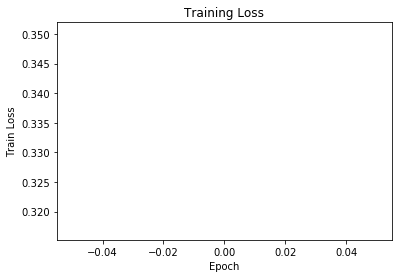

In [6]:
# Produce a figure illustrating the progress of behavior cloning
ax1 = gen_new_plot('Training Loss', 'Train Loss', 'Epoch')
ax1.plot(agent_bclone.history)
plt.show()

In [7]:
# Train Behavior Cloning Agent
stimulator.reset()
agent_bclone.clear_training_history()
for i in range(2, 11):
    print("Train Behavior Cloning, iter %i" % i)
    _ = stimulator.stimulate(agent_bclone, max_steps=args.max_timesteps, num_rollouts=args.num_rollouts, render=False, verbose=args.verbose)
    training_data = stimulator.stimulate(expert, max_steps=args.max_timesteps, num_rollouts=args.num_rollouts, render=False, verbose=0)
    agent_bclone.train(training_data, batch_size=args.batch_size, epochs=args.epochs, verbose=0)

[2017-09-13 22:54:51,657] Making new env: Hopper-v1


Train Behavior Cloning, iter 2
Return summary: mean=21.963512, std=3.925697
Train Behavior Cloning, iter 3
Return summary: mean=22.002487, std=0.753213
Train Behavior Cloning, iter 4
Return summary: mean=21.888009, std=2.911796
Train Behavior Cloning, iter 5
Return summary: mean=22.866119, std=0.785567
Train Behavior Cloning, iter 6
Return summary: mean=23.201122, std=0.510456
Train Behavior Cloning, iter 7
Return summary: mean=21.396254, std=5.142039
Train Behavior Cloning, iter 8
Return summary: mean=23.273546, std=0.349647
Train Behavior Cloning, iter 9
Return summary: mean=23.649385, std=0.631291
Train Behavior Cloning, iter 10
Return summary: mean=22.214523, std=0.910045


In [8]:
# Train DAgger Agent
stimulator.reset()
for i in range(2, 11):
    print("Train with DAgger, iter %i" % i)
    (stimulated_env, _) = stimulator.stimulate(agent_dagger, max_steps=args.max_timesteps, num_rollouts=args.num_rollouts, render=False, verbose=args.verbose)
    labels = stimulator.label_obs(expert, stimulated_env)
    with stimulator.session.as_default():
        agent_dagger.train((stimulated_env, labels), batch_size=args.batch_size, epochs=args.epochs, verbose=0)

[2017-09-13 22:55:05,245] Making new env: Hopper-v1


Train with DAgger, iter 2
Return summary: mean=4.148805, std=0.311949
Train with DAgger, iter 3
Return summary: mean=69.804884, std=1.363455
Train with DAgger, iter 4
Return summary: mean=92.834917, std=1.686580
Train with DAgger, iter 5
Return summary: mean=126.755704, std=2.615734
Train with DAgger, iter 6
Return summary: mean=189.903803, std=9.690247
Train with DAgger, iter 7
Return summary: mean=63.041339, std=1.783935
Train with DAgger, iter 8
Return summary: mean=218.805218, std=0.680470
Train with DAgger, iter 9
Return summary: mean=86.590354, std=2.597334
Train with DAgger, iter 10
Return summary: mean=264.711621, std=2.297312


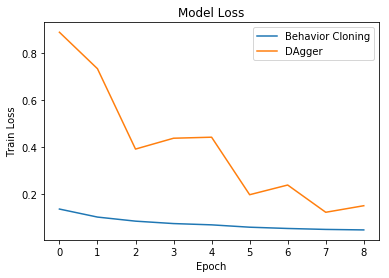

In [9]:
ax2 = gen_new_plot('Model Loss', 'Train Loss', 'Epoch')
ax2.plot(agent_bclone.history, label='Behavior Cloning')
ax2.plot(agent_dagger.history, label='DAgger')
ax2.legend()

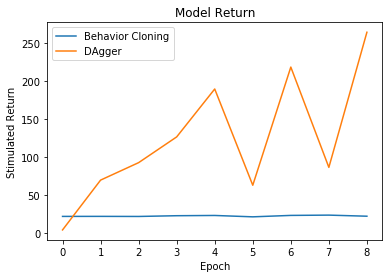

In [10]:
ax3 = gen_new_plot('Model Return', 'Stimulated Return', 'Epoch')
ax3.plot(agent_bclone.rewards, label='Behavior Cloning')
ax3.plot(agent_dagger.rewards, label='DAgger')
ax3.legend()

In [11]:
_ = stimulator.stimulate(agent_bclone, args.max_timesteps, args.num_rollouts, args.render, verbose=max(1,args.verbose))
_ = stimulator.stimulate(agent_dagger, args.max_timesteps, args.num_rollouts, args.render, verbose=max(1,args.verbose))

Return summary: mean=22.981717, std=1.338693
Return summary: mean=135.170767, std=4.757553


From the result of stimulation, we can conclude that DAgger agent behaves better in terms of reward than the Behavior Cloning agent.